# Model Problem Prototype

The purpose of this notebook is to demonstrate the use of the `regen` module `weak_form` function.  The purpose of the `weak_form` function is to take a partial differential equation and return the same equation in weak form.  One of the reasons the weak form of a PDE is advantageous for a finite element formulation is that second derivatives can be reduced to first derivatives by employing integration by parts. This puts fewer restrictions on the smothness of the solution variable.  However, applying the integration-by-parts formula to a PDE in a symbolic manipulation package such as `sympy` is non-trivial.

We begin by importing functions and classes we will need from the Python module `sympy`.  Calling the `init_printing()` function will give us nicely formatted output mathematics within the notebook.  The `regen` module is the Python module being developed here, whose goal is to start with a practical expression of a PDE (in LaTeX, for example, or using `sympy` syntax, as we do here) and from that, generate a `ResidualEvaluator` class, suitable for use in Albany.

In [1]:
from sympy import init_printing, preorder_traversal, Symbol, Function, Eq, Derivative, Tuple
import regen
init_printing()

The model problem we will be using for demonstration purposes comes from *Finite Elements: An Introduction, Volume I* by Eric B. Becker, Graham F. Carey, and J. Tinsley Oden.  In chapter 1 of that textbook, the authors develop a finite element method in the context of a model problem

$$
\begin{array}{ccc}
    -u'' + u = x, & 0 < x < 1 \\
    u(0) = 0,     & u(1) = 0
\end{array}
$$

where $u$ is our solution variable and the prime symbol $'$ indicates differention with respect to $x$.

To define our equation using `sympy`, we need to define `x` as a `Symbol` and `u` as a `Function` of `x`, then use the `Eq` and `Derivative` classes to define the equation:

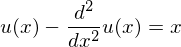

In [5]:
x = Symbol("x")
y = Symbol("y")
u = Function("u")(x)
model_prob = Eq(-Derivative(u,x,2) + u, x)
model_prob

Now the goal is to obtain the weak form of our model problem.  The `weak_form` function takes an `Eq` object as its first argument, the test function as its second argument, which we name `v`.  Note that through inspection, the `weak_form` function detects the solution variables, in this case `(u(x),)` and the domain variable `x`.

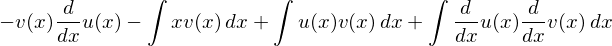

In [6]:
v = Function("v")(x)
weak_form = regen.weak_form(model_prob, v)
weak_form

The weak form is returned in the form of a `sympy.Expr` rather than a `sympy.Eq`, with the implication that the expression sums to zero.  Notice that the term involving the second derivative of $u$ has been replaced by two terms that involve the first derivatives of $u$ and $v$.

Open questions:
1. How much work will be involved to upgrade the `regen.weak_form()` function to handle higher dimensions?  The `sympy` objects already handle multi-dimensional objects, but the integration, including integration by parts, will have to be upgraded to handle higher dimensions.
1. The `regen.weak_form()` function can handle one or more equations, but has not yet been tested for multiple equations.
1. The work here was done in terms of indefinite integrals, but in practice, we need to include the boundary conditions.  The model problem here has Dirichlet boundary conditions and should be easy to handle, but more complicated boundary conditions could add complexity.